In [1]:
import datetime
import json
import matplotlib.pyplot as plt
from pathlib import Path

import pandas

## Get Ground Truth

In [2]:
def load_json(filename):
    with open(filename, 'r') as f:
        return json.load(f)

In [5]:
field_type_names = {
    1: 'cotton',
    2: 'safflower',
    3: 'flax',
    4: 'hops',
    5: 'sugar beets',
    6: 'corn',
    7: 'grain sorghum',
    8: 'sudan',
    9: 'castor beans',
    10: 'beans',
    11: 'misc field',
    12: 'sunflowers',
    13: 'hybrid sorghum/sudan',
    14: 'millet',
    15: 'sugar cane'
}

ground_truth_file = Path('src/ground-truth.geojson')
ground_truth = load_json(ground_truth_file)

def _get_field(field_id):
    return next(g for g in ground_truth if g['id'] == field_id)

def _get_subclass(field_id):
    field = _get_field(field_id)
    return field['properties']['SUBCLASS1']

_get_subclass('140')

'10'

## Get Image Statistics

In [6]:
src = Path('data/run2/results')

all_data = []
files = [f for f in src.glob('**/*.json')]
ignore_files = [] # ['2503.json', '20984.json']
filtered_files = [f for f in files if f.name not in ignore_files]

for f in filtered_files:
    print(f)
    # all_data.append(data)

data/run2/results/20839.json
data/run2/results/140.json
data/run2/results/20984.json


In [7]:
def get_date(scene_id):
    date_str = scene_id[:8]
    return datetime.datetime.strptime(date_str).date()

In [11]:
bands = ['blue', 'green', 'red', 'nir']

def flattened(f):
    field_id = f.stem
    print(field_id)
    data = load_json(f)
    flattened_data = []
    for entry in data:
        entry['field_id'] = field_id
        entry['field_type'] = _get_subclass(field_id)
        flattened_data.extend(flatten_entry(entry))
    return flattened_data

def to_datetime(date_str):
    return datetime.datetime.strptime(date_str[:10], "%Y-%m-%d").date()

def flatten_entry(e):
    entries = []
    for i, band in enumerate(['blue', 'green', 'red', 'nir']):
        new_e = {
            'date': to_datetime(e['date']),
            'band': band,
            'field_id': e['field_id'],
            'field_type': e['field_type']
        }
        for stat in ['mean', 'std', 'median', 'count']:
            new_e[stat] = e[stat][i] 

        entries.append(new_e)
    return entries
    
    
all_data = []
for f in filtered_files:
    all_data.extend(flattened(f))
    
all_data[0]

20839
140
20984


{'date': datetime.date(2022, 10, 28),
 'band': 'blue',
 'field_id': '20839',
 'field_type': '12',
 'mean': 813.141,
 'std': 32.67719570281391,
 'median': 813.0,
 'count': 2000.0}

In [12]:
df = pandas.DataFrame(all_data)

## Plot Band Statistics

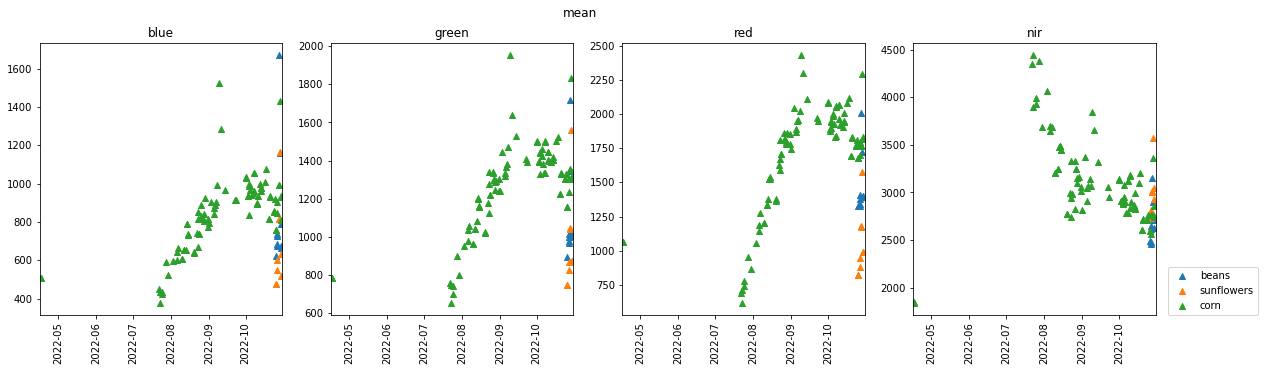

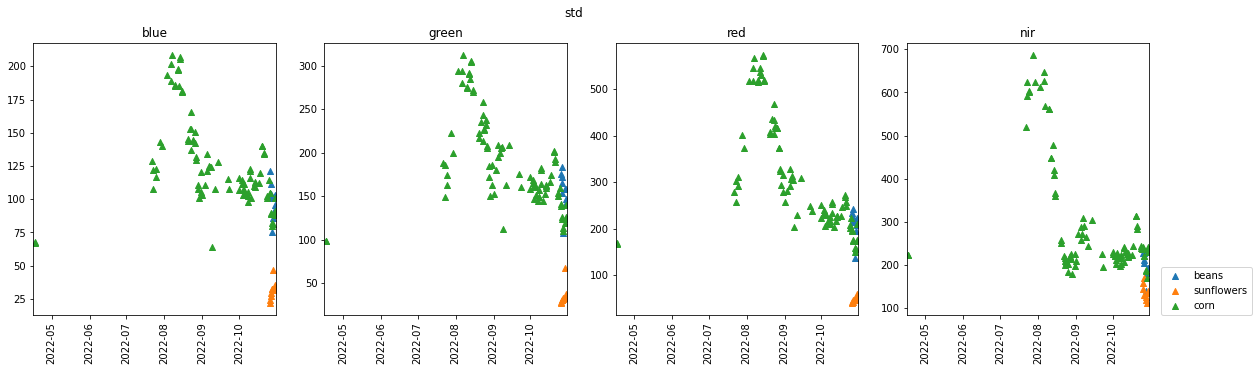

In [13]:
def plot_band_statistic(df, stat, title):
    for field_type, group in df.groupby(['field_type']):
        field_name = field_type_names[int(field_type)]

        x = group['date'].tolist()
        y = group[stat].tolist()
        plt.scatter(x, y, marker='^', label=field_name)
    
    all_x = df['date'].tolist()
    one_day = datetime.timedelta(days=1)
    plt.xlim(min(all_x) - one_day, max(all_x) + one_day)
    plt.margins(x=0)
    plt.xticks(rotation=90)
    plt.title(title)  

def plot_statistic(df, statistic, title=None):
    fig = plt.figure(figsize=(20,5))

    bands = ['blue', 'green', 'red', 'nir']
    
    title = title if title is not None else statistic
    fig.suptitle(title)

    for i, band in enumerate(bands):
        ax = fig.add_subplot(1,4,i+1)
        band_group = df[df['band'] == band]
        plot_band_statistic(band_group, statistic, band)

    ax.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)
    plt.show()

def plot_all_statistics(df):
    plot_statistic(df, 'mean')
    plot_statistic(df, 'std')

plot_all_statistics(df)